In [1]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import seaborn as sns
import warnings
import logging
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

In [24]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 8, nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.52 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 4.49 seconds


In [25]:
def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 20)
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)
rest_ocean = np.logical_and(~warmpool, ocean)
ocean = make_region_mask(-30, 30, 0, 360, pre_mask = ocean)

Convective only
figure size = 15 3.25
Mostly convective
figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


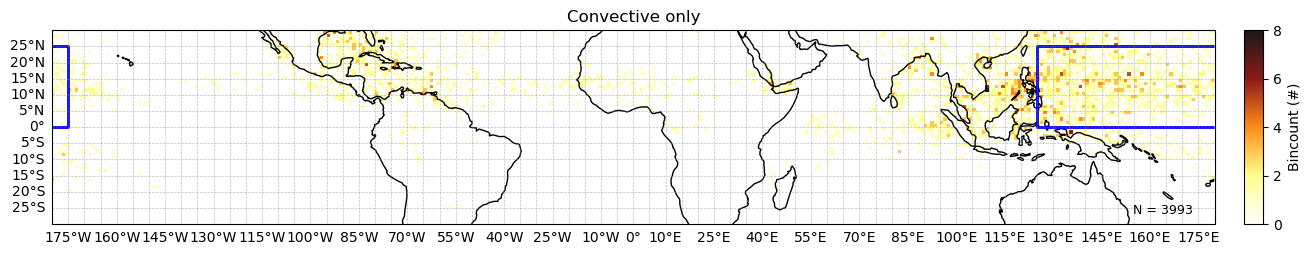

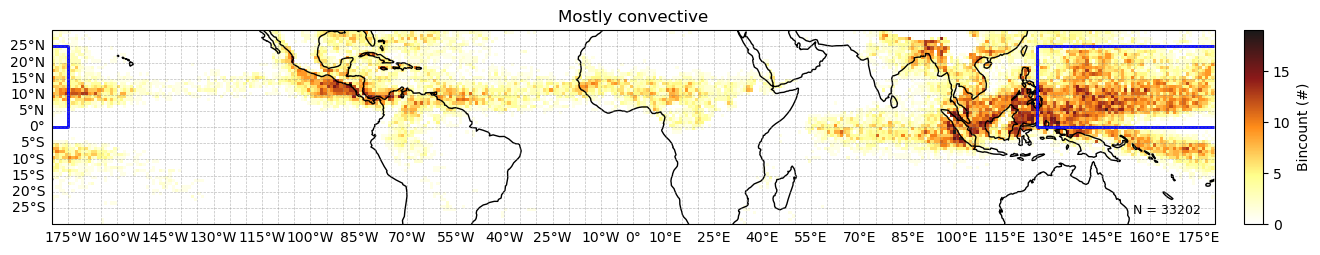

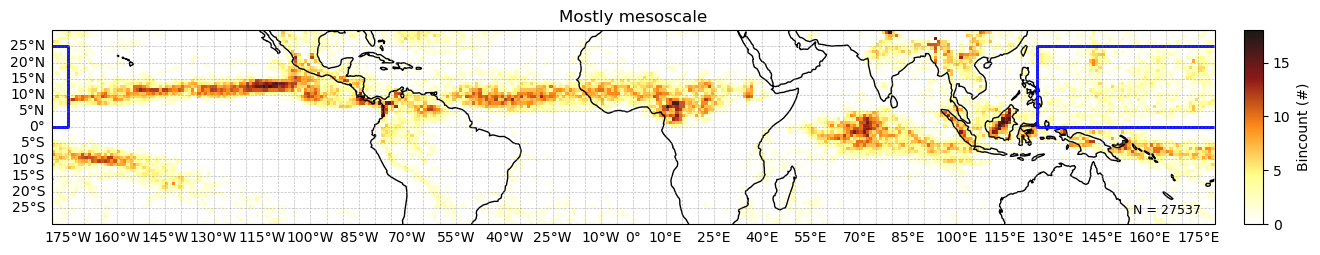

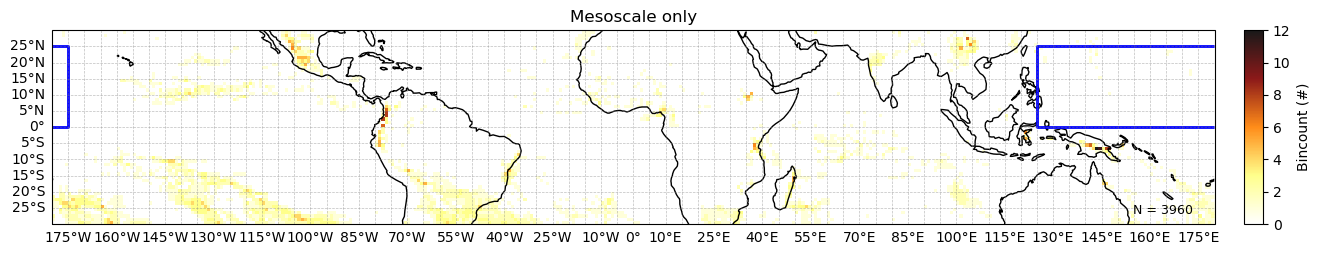

In [26]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 90
rank_acc_min = 90

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    # mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 125, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

(<Axes: xlabel='mean_unweighted_Prec', ylabel='cond_alpha_85_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x1479be15abf0>)

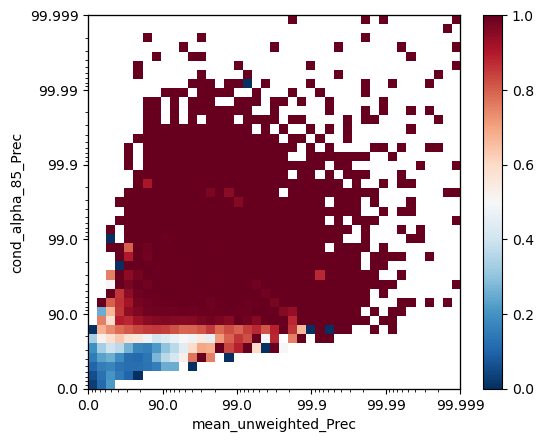

In [27]:
%matplotlib inline
data, noise, count = jd.get_mcs_bin_fraction(region_mask = None, bin_noise_treshold= 1)
jd.plot_data(data, noise, vbds = (0,1))

## Threshold, \alpha = 0.15

/scratchx/mcarenso/ipykernel_2935276/3448876461.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


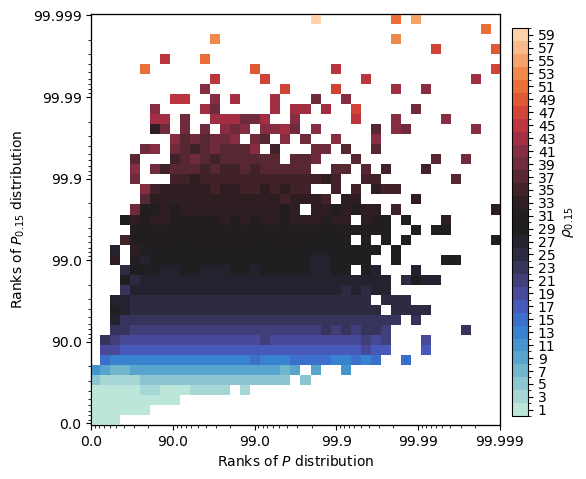

In [28]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 62, 1)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_85', mask = ocean, cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\rho_{0.15} $')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

/scratchx/mcarenso/ipykernel_2935276/773860344.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


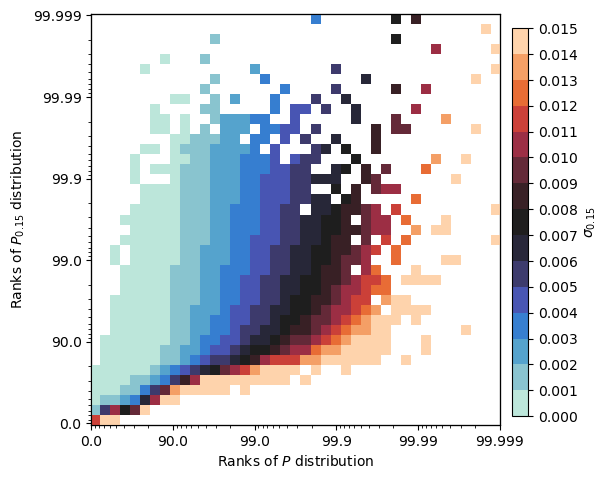

In [29]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.015+0.0005, 0.0005)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]


norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', mask = ocean, cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\sigma_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=boundaries, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15}$')
plt.tight_layout()
plt.savefig('discrete_surface_ratio_on_joint_dist.png', bbox_inches='tight')

# Env

In [30]:
def denormalize(x, min_val, max_val):
        """"
        for optimzing in min-max standardize space
        """
        return x * (max_val - min_val) + min_val

### sst

In [9]:
# %matplotlib inline 
# fig, ax  = plt.subplots(figsize = (5.35, 4.85))

# cmap = sns.color_palette("icefire", as_cmap=True)
# vmin, vmax, vstep = 298, 302, 0.5
# n_steps = (vmax-vmin)/vstep +1 
# values_and_boundaries = np.arange(vmin, vmax+vstep, vstep)
# values = values_and_boundaries[1::2]
# boundaries  = values_and_boundaries[::2]


# norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# ax, cbar = jd.plot_var_id_func_over_jdist('T2mm', func = 'mean', mask = ocean, cmap = cmap, norm = norm, fig = fig, ax = ax)
# cbar.remove()

# # ax.set_title(r"$\sigma_{0.5} $ for joint bins of $(P; P_{0.5})$")
# ax.set_xlabel(r"Ranks of $P$ distribution")
# ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


# cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=boundaries, spacing='proportional')

# cbar.set_label(r'$\sigma_{0.15}$')
# plt.tight_layout()
# plt.savefig('discrete_surface_ratio_on_joint_dist.png', bbox_inches='tight')

In [31]:
def plot_var_boundaries_on_jdist(self, var_id, func, boundaries, mask, stipple_threshold = 0.33, figsize = (5.35, 4.85)):
    ## prepare data
    key = func+'_'+var_id

    if func == 'MCS':
        da_var = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")[var_id]
    # Trying to avoid the prec bug, maybe it's due to prec dataset already being open within jd
    elif var_id == "Prec" : 
        da_var = self.prec.sortby("days")[key]
    else :  
        da_var = self.grid.get_var_id_ds(var_id).sortby("days")[key]
        
    var_days = list(da_var.days.values)
    if isinstance(mask, np.ndarray):
        mask  = mask[:,:,:len(var_days)] # adapt mask days length
    da_var = da_var.where(mask)
    var = da_var.values.ravel()

    reduced_prec = self.prec.sel(days = var_days)

    ## compute conditionalized data
    bincount_where_var_cond = []
    labels = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]):
        spatial_var_where_cond = list(np.where((da_var.values>cond_inf) & (da_var.values<=cond_sup)))
        # print([(spatial_var_where_cond[i]) for i in range(3)])
        sample1_where_cond = reduced_prec[self.var_id_1].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
        sample2_where_cond = reduced_prec[self.var_id_2].where(mask).values[spatial_var_where_cond[0], spatial_var_where_cond[1], spatial_var_where_cond[2]] #this flattens
        bincount_cond, _, _ = np.histogram2d(x=sample1_where_cond, y=sample2_where_cond, bins = (self.bins1, self.bins2), density = False)
        bincount_where_var_cond.append(bincount_cond)
        labels.append(f"{cond_inf} < {key} <= {cond_sup}")

    # fetch proeminent boundaries and 2nd, then compute density difference between both 
    null = np.full_like(bincount_where_var_cond[0], 0)
    cond_stacked = np.stack([null]+bincount_where_var_cond)
    cond_max = np.argmax(cond_stacked, axis=0)
    rows, cols = np.indices(cond_max.shape)
    temp_cond_stack = np.copy(cond_stacked)
    temp_cond_stack[cond_max, rows, cols] = -np.inf
    cond_max2 = np.argmax(temp_cond_stack, axis=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cond_max_diff = (cond_stacked[cond_max, rows, cols] - cond_stacked[cond_max2, rows, cols])/np.sum(cond_stacked, axis = 0)    
    cond_max = cond_max.astype(float)
    cond_max[cond_max == 0] = np.nan  # Now you can assign np.nan to it

    # plot and stipple
    fig, ax  = plt.subplots(figsize = figsize)
    cmap = sns.color_palette("icefire", as_cmap=True)
    ax, cb = jd.plot_data(cond_max, cmap = cmap, fig=fig, ax=ax)
    cb.remove()

    stipple_mask = cond_max_diff<stipple_threshold
    x_indices, y_indices = np.where(stipple_mask)
    x = np.linspace(0, cond_max.shape[0], cond_max.shape[0]+1 )
    y = np.linspace(0, cond_max.shape[1], cond_max.shape[1]+1)
    x_stipple = x[x_indices]
    y_stipple = y[y_indices]
    plt.scatter(x_stipple, y_stipple, color='black', s=5)

    ax.set_xlabel(r"Ranks of $P$ distribution")
    ax.set_ylabel(r"Ranks of $P_{0.5}$ distribution")

    # make a fancy colorbar
    norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)
    cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
    ticks_values = []
    labels = []
    for cond_inf, cond_sup in zip(boundaries[:-1], boundaries[1:]): 
        labels.append(rf"[{np.round(cond_inf, 2)},{np.round(cond_sup, 2)}]")
        ticks_values.append((cond_inf+cond_sup)/2)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=ticks_values, spacing='uniform') #spacing = 'proportional'
    cbar.set_label(var_id)
    cbar.set_ticklabels(labels)

    ax.set_title(f"{var_id}")
    plt.tight_layout()
    plt.show()

/scratchx/mcarenso/ipykernel_2935276/3601058752.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


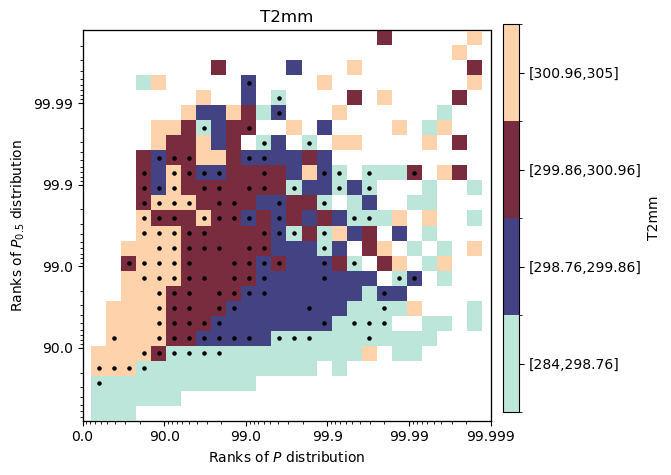

In [11]:
var_id = "T2mm"
func  = "mean"
var_cond_list = [284, 298.76, 299.86, 300.96, 305]
stipple_threshold=0.2
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = var_cond_list, mask = True, stipple_threshold=stipple_threshold)

In [23]:
len(jd.dist1.bins)
jd.dist1.ranks

array([ 0.        , 36.90426555, 60.18928294, 74.88113568, 84.15106808,
       90.        , 93.69042656, 96.01892829, 97.48811357, 98.41510681,
       99.        , 99.36904266, 99.60189283, 99.74881136, 99.84151068,
       99.9       , 99.93690427, 99.96018928, 99.97488114, 99.98415107,
       99.99      , 99.99369043, 99.99601893, 99.99748811, 99.99841511,
       99.999     ])

/scratchx/mcarenso/ipykernel_2935276/3601058752.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


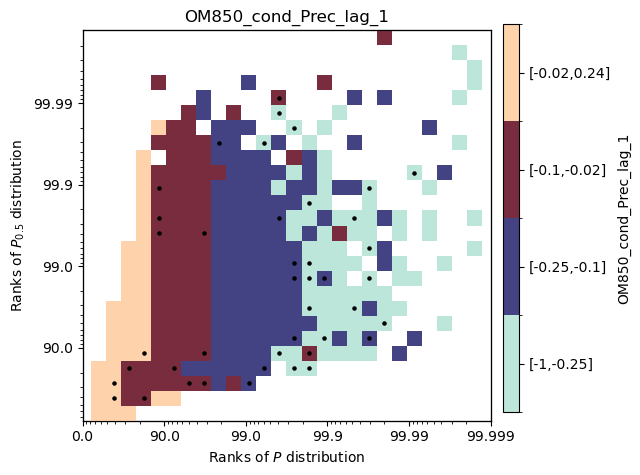

In [12]:
var_id = "OM850_cond_Prec_lag_1"
func = "mean"
# Optimal boundaries: [-6.06259579e-01  1.20671283e-05]

var_cond_list = [-1, -0.25, -0.1, -0.02, 0.24]
stipple_threshold=0.2
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = var_cond_list, mask = ocean, stipple_threshold=stipple_threshold)

/scratchx/mcarenso/ipykernel_2935276/3601058752.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


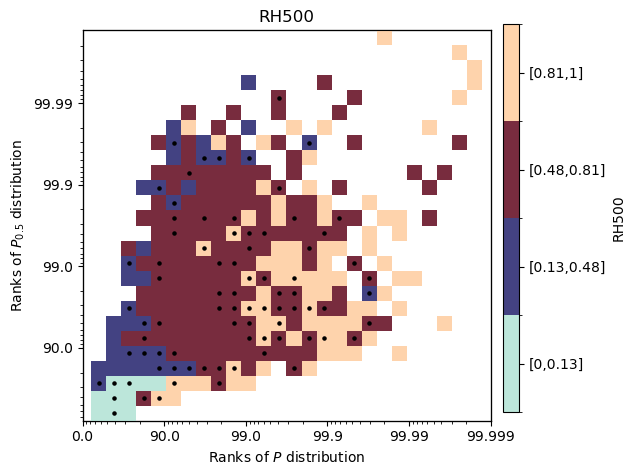

In [13]:
var_id = "RH500"
func = "mean"
# Optimal boundaries: [0.13553818 0.28590275 0.60529872]

var_cond_list = [0, 0.13, 0.485, 0.81, 1]
stipple_threshold=0.2
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = var_cond_list, mask = ocean, stipple_threshold=stipple_threshold)

## MCS

In [14]:
ds_storms = xr.open_dataset(st.file_storms)
ds_storms

<xarray.Dataset>
Dimensions:              (DCS_number: 287031, label: 287031, time: 960)
Coordinates:
  * DCS_number           (DCS_number) int64 1 2 3 4 ... 304338 304339 304343
  * label                (label) int64 1 2 3 4 5 ... 304337 304338 304339 304343
  * time                 (time) int64 960 961 962 963 ... 1916 1917 1918 1919
Data variables: (12/53)
    INT_TbMin            (DCS_number) float64 ...
    INT_UTC_timeEnd      (DCS_number) int64 ...
    INT_UTC_timeInit     (DCS_number) int64 ...
    INT_classif          (DCS_number) int64 ...
    INT_classif_JIRAK    (DCS_number) float64 ...
    INT_classif_MADDOX   (DCS_number) float64 ...
    ...                   ...
    LC_tbavg_241K        (label, time) float64 ...
    LC_tbmin             (label, time) float64 ...
    LC_velocity          (label, time) float64 ...
    LC_x                 (label, time) float64 ...
    LC_y                 (label, time) float64 ...
    QCgeo_IRimage        (label, time) float64 ...

In [15]:
np.sum(ds_storms.growth_rate < 0 )

AttributeError: 'Dataset' object has no attribute 'growth_rate'

In [15]:
import os 

def add_mcs_var_from_labels(self, var_id, norm_rel_surf = 'lin', compat = 'overide'):
    """
    Not the same var_id than usual
    """
    ds_mcs = self.grid.get_var_id_ds(self.st_label_var_id).sortby("days")
    
    ds_var_by_label = xr.open_dataset(self.file_storms)[var_id] 
    arr = np.full(np.shape(ds_mcs[self.st_label_var_id])[:-1], np.nan)
    # Messy stuff bc MCS in here
    for i_lat ,lat in enumerate(ds_mcs.lat_global):
        for i_lon, lon in enumerate(ds_mcs.lon_global):
            for i_day, day in enumerate(ds_mcs.days):
                sub_ds = ds_mcs.sel(days = day, lat_global = lat, lon_global = lon)
                labels = sub_ds[self.st_label_var_id].values
                rel_surfaces = sub_ds["Rel_surface"].values
                valid_labels = labels[~np.isnan(labels)].astype('int')
                if len(valid_labels)>0:
                    labels = valid_labels[np.isin(valid_labels, ds_var_by_label.label)]
                    rel_surfaces = rel_surfaces[:len(valid_labels)][np.isin(valid_labels, ds_var_by_label.label)]
                    if len(labels)>0:
                        var_values = ds_var_by_label.loc[dict(label=labels)].values          
                        rel_surfaces = rel_surfaces[:len(labels)] ##this filter here should be pointless...
                        if norm_rel_surf == 'lin' : 
                            adjustment = np.sum(rel_surfaces)
                            rel_surfaces = rel_surfaces / adjustment # so that it sums up to 1 
                        if norm_rel_surf == 'fro' :
                            frob = np.linalg.norm(rel_surfaces)
                            rel_surfaces = rel_surfaces / frob
                        out = np.average(var_values, weights = rel_surfaces)
                        if out < 0 :
                            print(valid_labels, labels, var_values, rel_surfaces)
                        arr[i_lat, i_lon, i_day] = np.average(var_values, weights = rel_surfaces) 
                        
    if norm_rel_surf == 'lin': 
        var_id = var_id+'_surf_adj'
    elif norm_rel_surf == 'fro':
        var_id = var_id+'_surf_fro_adj'

    da_var = xr.DataArray(arr, dims=["lat_global", "lon_global", "days"],
                            coords={"lat_global": ds_mcs.lat_global,
                                    "lon_global": ds_mcs.lon_global,
                                    "days": ds_mcs.days})
    

    self.grid.safe_merge_and_save(ds_mcs, da_var, var_id, self.st_label_var_id, compat='no_conflicts')

    return arr

In [16]:
def safe_merge_and_save(self, ds_mcs, da_var, var_id, st_label_var_id, compat='override'):
    """
    Safely merges a DataArray into a Dataset and saves the merged Dataset to a NetCDF file.
    Includes checks for successful merge and file operations.

    Parameters:
    - ds_mcs: xarray.Dataset, the original dataset to merge into.
    - da_var: xarray.DataArray, the data array to merge.
    - var_id: str, the variable ID to rename `da_var` to in `ds_mcs`.
    - grid: object, should have a method `get_var_ds_file` returning the file path for `st_label_var_id`.
    - st_label_var_id: str, the label variable ID used to retrieve the file path from `grid`.
    - compat: str, compatibility mode for xarray.merge. Default is 'no_conflicts'.

    Returns:
    - bool: True if the operation was successful, False otherwise.
    """
    try:
        # Attempt to merge da_var into ds_mcs
        ds_mcs = xr.merge([ds_mcs, da_var.rename(var_id)], compat=compat)

        # Check if the merge was successful by comparing the merged dataset's variable with the original da_var
        if not ds_mcs[var_id].equals(da_var):
            logging.error("Merge failed: da_var values do not match in the merged dataset.")
            print("Try to replace instead")
            ds_mcs[var_id] = da_var.rename(var_id)

        # Retrieve the file path
        file_mcs_ds = self.get_var_ds_file(st_label_var_id)

        # Check if the file exists before attempting to delete
        if os.path.exists(file_mcs_ds):
            os.remove(file_mcs_ds)
            # print(os.path.exists(file_mcs_ds))
        else:
            logging.warning(f"File {file_mcs_ds} does not exist, nothing to delete.")

        print(ds_mcs[var_id].equals(da_var))
        # Save the merged dataset to the file
        ds_mcs.to_netcdf(file_mcs_ds)

    except Exception as e:
        logging.exception(f"An error occurred during the merge and save process: {e}")
        return False

    return True

In [17]:
# import os 
# ds_storms['norm_growth_rate'] = ds_storms['growth_rate'] / ds_storms['s_max']
# ds_storms['growth_rate'] = ds_storms['growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1) & (ds_storms['r_squared'] >= 0.8) , np.nan)
# ds_storms['s_max'] = ds_storms['s_max'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1) & (ds_storms['r_squared'] >= 0.8) , np.nan)
# ds_storms['norm_growth_rate'] = ds_storms['norm_growth_rate'].where((ds_storms['norm_growth_rate'] >= 0) & (ds_storms['norm_growth_rate'] <= 1), np.nan)

# os.remove(st.file_storms)
# ds_storms.to_netcdf(st.file_storms)

# arr_gr = add_mcs_var_from_labels(jd, "growth_rate", norm_rel_surf = ' clin', compat='override')
# add_mcs_var_from_labels(jd, "s_max", norm_rel_surf = 'lin', compat='override')
# add_mcs_var_from_labels(jd, "duration", norm_rel_surf = 'lin', compat='override')
# add_mcs_var_from_labels(jd, "s_max", norm_rel_surf = 'lin', compat='override')



In [72]:
ds_storms.sel(label = 174481).growth_rate.values

array(1648.03608992)

/scratchx/mcarenso/ipykernel_2475229/4133986386.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


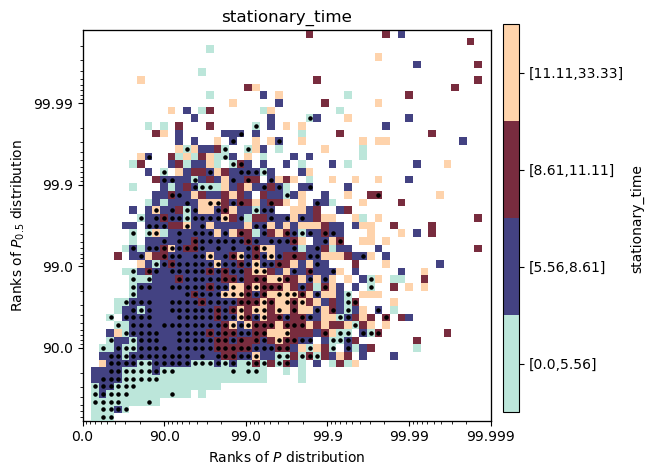

In [122]:
var_id = "stationary_time"
var_cond_list = [0, 20000, 31000, 40000, 120000]
func = "MCS"
stipple_threshold=0.2
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = var_cond_list, mask = ocean, stipple_threshold=stipple_threshold)

Avoid conv mcs as 1 im not sure its better than mcs and 2 i didn't make them in other lowRes simulations

In [15]:
# ## Load storms 
# st = storm_tracker.StormTracker(gr, label_var_id = "Conv_MCS_label", overwrite = False)

# ##
# jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = True, dist_mask = ocean)

In [28]:
mcs = gr.get_var_id_ds('MCS_label')

/scratchx/mcarenso/ipykernel_2475229/2112388619.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


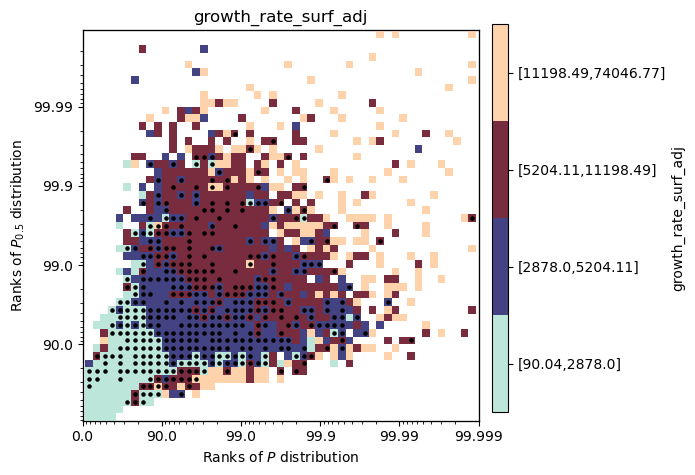

In [168]:
var_id = "growth_rate_surf_adj"
var_cond_list = [0, 0.037697175819446774, 0.069149481149857235, 0.150202022573268, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/scratchx/mcarenso/ipykernel_2475229/2112388619.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


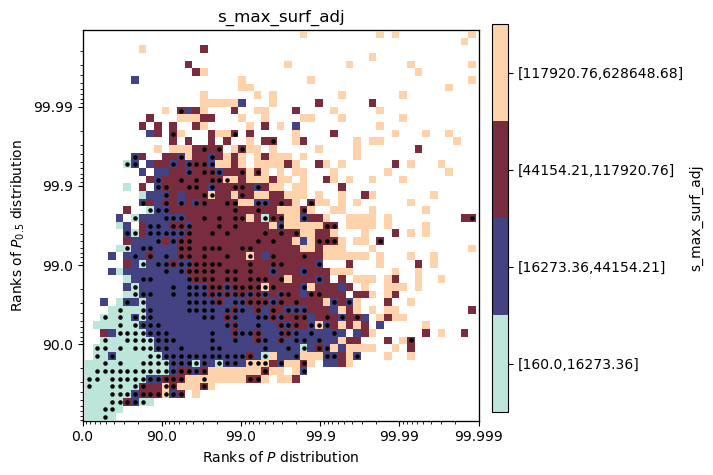

In [163]:
var_id = "s_max_surf_adj"
var_cond_list = [0, 0.02563826276546143, 0.07, 0.1873713325542578, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/scratchx/mcarenso/ipykernel_2475229/2112388619.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


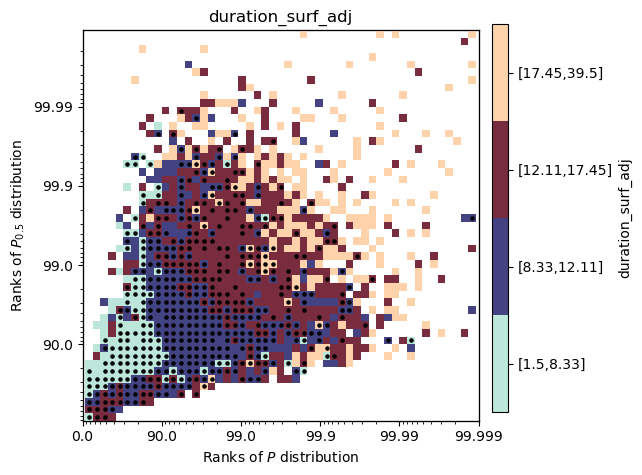

In [157]:
var_id = "duration_surf_adj"
var_cond_list = [0, 0.17966080434970302, 0.2790876948038112, 0.41969485077416124, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

/scratchx/mcarenso/ipykernel_2475229/2112388619.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


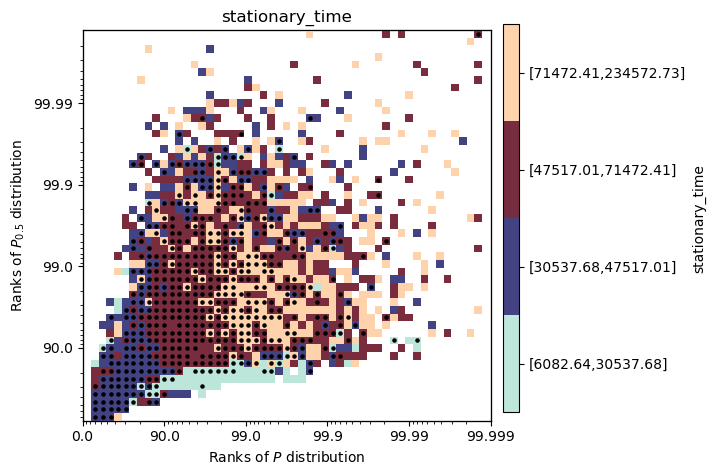

In [158]:
var_id = "stationary_time"
var_cond_list = [0,0.10702886818149357, 0.18133991700942786, 0.2861820674566714, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)

/scratchx/mcarenso/ipykernel_2475229/2112388619.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


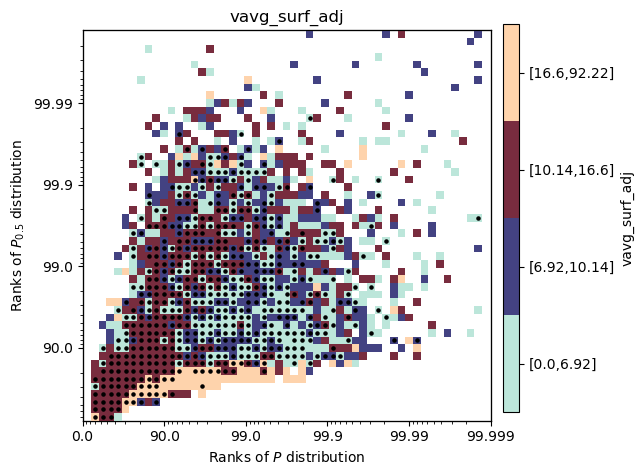

In [162]:
var_id = "vavg_surf_adj"
var_cond_list = [0, 0.075, 0.11, 0.18, 1]
func = "MCS"
stipple_threshold=0.2
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
plot_var_boundaries_on_jdist(jd, var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)

In [24]:
# storms = xr.open_dataset(st.file_storms)
# storm = storms.isel(label = 9958)

# print(storm.duration.values, (storm.Utime_End.values/1800 -  storm.Utime_Init.values/1800)+1)

3.0 12.0
